All of the subsequent questions refer to the combined PD1/2 dataset 


In [81]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.patches as mpatches
import matplotlib
matplotlib.style.use('ggplot')

import pandas as pd
import numpy as np
import timeit 
import os
from datetime import datetime
from datetime import timedelta

#NB : timeit.default_timer() auto chooses timeing function for os, nicer than time.time() or time.clock()
print ("libraries imported")

libraries imported


In [2]:
start_time = timeit.default_timer()
df1 = pd.read_csv('PD1.csv')
elapsed = timeit.default_timer() - start_time
print ("elapsed time : ", elapsed)

elapsed time :  3.2195579302980972


In [3]:
start_time = timeit.default_timer()
df2 = pd.read_csv('PD2.csv')
elapsed = timeit.default_timer() - start_time
print ("elapsed time : ", elapsed)

elapsed time :  3.0396463850817157


In [4]:
start_time = timeit.default_timer()
df = df1.set_index('TimeStamp').join(df2.set_index('TimeStamp'))
elapsed = timeit.default_timer() - start_time
print ("elapsed time : ", elapsed)
#print (df.head(4))

elapsed time :  0.3561942416869419


In [5]:
start_time = timeit.default_timer()
df.index = pd.to_datetime(df.index)
elapsed = timeit.default_timer() - start_time
print ("elapsed time : ", elapsed)
#print (df.head())

elapsed time :  0.021719121053522805


In [6]:
print(df.shape)
dfColNames = list(df)


(60000, 792)


2. Imputation  
a. Remove any sensors where values are missing in >10% of rows. 

In [7]:
print ("Number of NAN values", df.shape[0]-df['346TT035/PV.V'].count())
print ("% of NAN values", (df.shape[0]-df['346TT035/PV.V'].count())/df.shape[0])


Number of NAN values 1544
% of NAN values 0.0257333333333


In [8]:
cols2Drop = []
for colName in dfColNames:
    percentNaN = (df.shape[0]-df[colName].count())/df.shape[0]
    #print ("colName:", colName, ",\t\t\t percentNaN:", percentNaN)
    if percentNaN > 0.1:
        #print ("colName: %40s  percentNaN: %f" % (colName, percentNaN) )
        cols2Drop.append(colName)
#print ("cols2Drop=", cols2Drop)
print ("len(cols2Drop):", len(cols2Drop))
print (df.shape)
df = df.drop(cols2Drop, axis=1)
print (df.shape)

len(cols2Drop): 311
(60000, 792)
(60000, 481)


#b. Delete those rows for which sensor 346TT035/PV.V has missing values. 

In [9]:
df['346TT035/PV.V'].shape

(60000,)

In [10]:
print ("Number of NAN values", df.shape[0]-df['346TT035/PV.V'].count())
print ("Number of Non NAN values", df['346TT035/PV.V'].count())

print (type(df))

Number of NAN values 1544
Number of Non NAN values 58456
<class 'pandas.core.frame.DataFrame'>


In [11]:
df.dropna(subset=['346TT035/PV.V'], how='all', inplace = True)

In [12]:
df.shape

(58456, 481)

c. 
For sensor PrcTotals/321-WQ-024.V, replace missing values with the average value for the sensor.   
What would be a better imputation scheme & why? 

In [13]:
print ("Number of NAN values", df.shape[0]-df['PrcTotals/321-WQ-024.V'].count())
print ("Number of Non NAN values", df['PrcTotals/321-WQ-024.V'].count())

print (type(df))
df['PrcTotals/321-WQ-024.V'].describe()

Number of NAN values 0
Number of Non NAN values 58456
<class 'pandas.core.frame.DataFrame'>


count    58456.000000
mean     21214.505728
std        615.138200
min      20217.620000
25%      20707.700000
50%      21288.975000
75%      21801.280000
max      22215.140000
Name: PrcTotals/321-WQ-024.V, dtype: float64

NB: there are _ZERO_ missing values in column 'PrcTotals/321-WQ-024.V'.  
Question appears to be flawed or misleading   
What would be a better imputation scheme & why? ans: Question is redundant as there were no missing values in column.

<IPython.core.display.Javascript object>


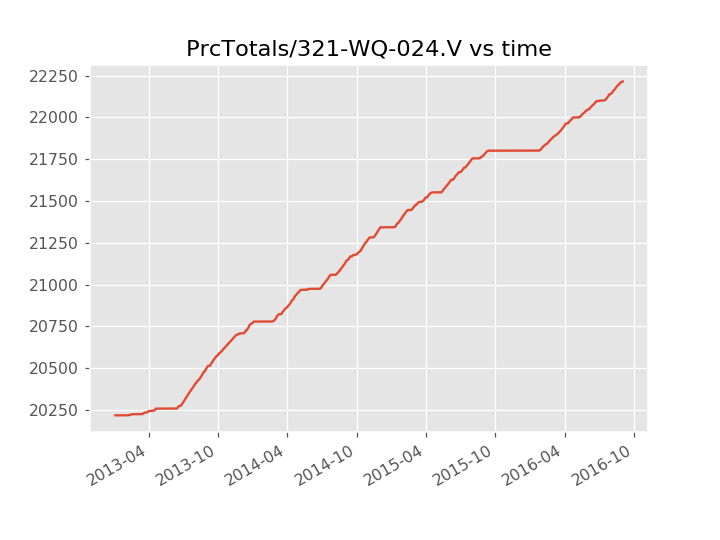

In [14]:
plt.close('all')
fig, ax = plt.subplots(1)
plt.title('PrcTotals/321-WQ-024.V vs time')
ax.plot(df['PrcTotals/321-WQ-024.V'])

# rotate and align the tick labels so they look better
fig.autofmt_xdate()

# use a more precise date string for the x axis locations in the
# toolbar
import matplotlib.dates as mdates
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
#plt.title('fig.autofmt_xdate fixes the labels')

In [15]:
#from fancyimpute import KNN
## X is the complete data matrix
# X_incomplete has the same values as X except a subset have been replace with NaN

# Use 3 nearest rows which have a feature to fill in each row's missing features
#X_filled_knn = KNN(k=3).complete(X_incomplete)

d. Challenge question (optional):   
Impute all other missing sensor values using a more robust technique   
(including but not limited to interpolation or kNN imputation).   
What are the advantages & disadvantages of your chosen imputation technique? 

In [91]:
#summaries missing sensor values in all columns
print ( "%45s %10s %10s" % ("Column Name", "#Non NAN", "Count NAN") )
for colName in list(df):
    #print (colName, df[colName].count(), df.shape[0]-df[colName].count())
    print ( "%45s %10d %10d" % (colName, df[colName].count(), df.shape[0]-df[colName].count() ))
    #print ("%35s %7d " % colName )


                                  Column Name   #Non NAN  Count NAN
                    Utilities_Shutdown/USD1.Q      58453          3
          ACP:P:C2$T$Control/322-PSL-100_DB.Q      58449          7
                             mould_matte_SiO2      58446         10
                    PrcCtl_Coal/Rd_Coal_PV1.V      58198        258
         AS01_DATA_FROM_AS05/377-PIT-002_Lo.Q      58203        253
         ACP:P:C2$Matte$Tap$2/322-HS-628_DB.Q      58203        253
                             322-PIT-105/PV.V      58433         23
                              534FIT504/PV2.V      58197        259
                         AS14_Data_AS01/PV7.V      58434         22
            ACP:P:C2$Slag$Tap/322-HS-718_DB.Q      58191        265
                            635FIT256/PV.QBAD      58202        254
                               635FIT231/PV.V      58435         21
              AS05_PLC_COMMS/AS5-AS1commsOK.Q      58456          0
                       PrcTotals/372-WQ-013.V   

cleanup NaN values - simple version.

In [98]:
#simple replace NaN values with mean.
tempMean = df['master_feed_setpoint'].mean()
print ("tempMean:", tempMean)
df['master_feed_setpoint'] = df['master_feed_setpoint'].fillna(tempMean)
print ("master_feed_setpoint : Number of NAN values", df.shape[0]-df['master_feed_setpoint'].count())

tempMean: 24.645129917520887
master_feed_setpoint : Number of NAN values 0


In [23]:
#simple replace NaN values with mean.
tempMean = df['master_feed_rate'].mean()
print ("tempMean:", tempMean, type(tempMean))
df['master_feed_rate'] = df['master_feed_rate'].fillna(tempMean)
print ("master_feed_rate : Number of NAN values", df.shape[0]-df['master_feed_rate'].count())

<class 'numpy.float64'>
tempMean: 22.82385424037506 <class 'float'>
master_feed_rate : Number of NAN values 0


3. Visualisation:   
a. The target for the feed rate into the process (“master_feed_rate”) is 42 tons per hour.   
Create a graph that helps to determine if this is achieved.   

b. The value of “master_feed_setpoint” represents the set point of the master feed rate into the process.   
“master_feed_rate” represents the actual value of the feed rate. 


Explain graphically the relationship between these two sensors.   
How well does the actual value match its set point? 


startTime: 2013-01-02T10:11:30.000000000 <class 'numpy.datetime64'>
endTime: 2013-01-13T02:57:30.000000000 <class 'numpy.datetime64'>


<IPython.core.display.Javascript object>


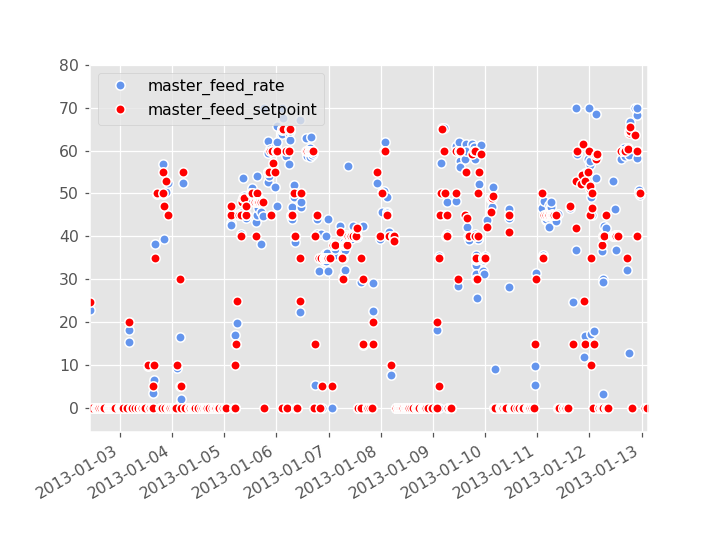

(-5.6388790000000002, 80.0)

In [93]:
plt.close('all')
temp = 500

startTime = df.index.values[0]
endTime = df.index.values[temp]
print ("startTime:", startTime, type(startTime))
print ("endTime:", endTime, type(endTime))

fig, ax = plt.subplots()
ax.plot_date(df.index.values[0:temp], df['master_feed_rate'][0:temp], markerfacecolor='CornflowerBlue', markeredgecolor='white', label='master_feed_rate')
ax.plot_date(df.index.values[0:temp], df['master_feed_setpoint'][0:temp], markerfacecolor='Red', markeredgecolor='white', label='master_feed_setpoint')
ax.legend(loc="upper left")
fig.autofmt_xdate()
ax.set_xlim([df.index.values[0], df.index.values[temp] ])
ax.set_ylim( [ min(df['master_feed_rate']), max(df['master_feed_rate']) ])

#todo: position legend outside plot area, this method should work.
#https://stackoverflow.com/questions/30413789/matplotlib-automatic-legend-outside-plot

Notes:  
- subsection of time period plotted to enable clarity.  
- overshooting and undershooting evident, needs analysis to clarify.  
- lag between 'master_feed_setpoint' and 'master_feed_rate' probably exists and is to be expected.  